# Proyecto Integrador — Maestría en Inteligencia Artificial Aplicada

## Avance 4. Modelos Alternativos — Plataforma PACS/RIS

---

**Cuarto Avance:** Ya sabemos que los datos sirven para predecir engagement (el baseline de la Fase 3 lo confirmó). Ahora, ¿qué modelo lo hace mejor? En esta fase entrenamos 8 algoritmos distintos, los comparamos de frente, afinamos los dos mejores y elegimos un ganador.

**Equipo 4**

### Responsables — Fase 4

| Actividad | Andrés Castillo Nassar | Renzo Felipe Chávez Pulgar | César Manuel Tirado Peraza |
|---|---|---|---|
| Selección de algoritmos candidatos | Validar que los modelos elegidos tienen sentido para el tipo de datos | Implementar los 8 modelos con configuración inicial | Justificar la diversidad de algoritmos seleccionados |
| Entrenamiento y evaluación | Interpretar resultados desde la lógica de negocio | Ejecutar entrenamiento en las versiones A y B del dataset | Comparar métricas, generar tablas y visualizaciones |
| Selección de los 2 mejores | Validar que el ranking tiene sentido operativo | Preparar los modelos para tuning | Analizar trade-offs entre rendimiento y complejidad |
| Ajuste de hiperparámetros | — | Ejecutar RandomizedSearchCV para ambos modelos | Interpretar resultados del tuning y diagnosticar sobreajuste |
| Elección del modelo final | Dar el visto bueno desde la perspectiva de negocio | Generar el modelo final entrenado | Documentar la comparación final y justificar la elección |

> **Roles:** Andrés → Experto de Dominio · Renzo → Ingeniero ML · César → Científico de Datos

## Contenido

1. [Conexión con la Fase 3 y configuración](#config)
2. [Reconstrucción del dataset (pipeline Fases 1-2)](#pipeline)
3. [Los 8 modelos candidatos](#modelos)
4. [Comparación de rendimiento](#comparacion)
5. [Los 2 mejores modelos](#top2)
6. [Ajuste de hiperparámetros](#tuning)
7. [Modelo individual final](#final)
8. [Conclusiones y qué sigue en la Fase 5](#conclusiones)

<a name="config"></a>
## 1. Conexión con la Fase 3 y configuración

### 1.1 De dónde partimos

La Fase 3 nos dejó un baseline claro: la Regresión Logística alcanzó un **F1-macro de 0.7225** usando el dataset B (escalado). Cualquier modelo nuevo tiene que superar esa cifra para justificar su complejidad adicional.

| Referencia de la Fase 3 | Valor |
|---|---|
| F1-macro del baseline (LogReg) | 0.7225 |
| F1-macro del azar (Dummy) | 0.2806 |
| Métrica principal | F1-macro |
| Dataset preferido | B (StandardScaler) para modelos sensibles a escala |
| Split | 80/20 estratificado (se mantiene idéntico) |

### 1.2 Qué vamos a hacer

| Paso | Objetivo |
|---|---|
| Entrenar 8 modelos diversos | Explorar distintas familias de algoritmos |
| Comparar rendimiento | Identificar cuáles superan al baseline y por cuánto |
| Seleccionar los 2 mejores | Elegir los candidatos con mejor balance rendimiento-generalización |
| Ajustar hiperparámetros | Exprimir el máximo rendimiento de cada finalista |
| Elegir el modelo final | Decidir cuál es el mejor modelo individual para este problema |

In [1]:
# CONFIGURACIÓN DEL ENTORNO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, warnings, time
from scipy.stats import skew

# Sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    RandomizedSearchCV, learning_curve
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    cohen_kappa_score, classification_report, confusion_matrix,
    make_scorer
)

# Gradient Boosting avanzado
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (12, 5), 'font.size': 10})

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Librerías cargadas correctamente')

Librerías cargadas correctamente


<a name="pipeline"></a>
## 2. Reconstrucción del dataset (pipeline Fases 1-2)

Replicamos el pipeline completo para que el notebook sea autocontenido. El resultado son los mismos tres datasets (A, B, C) y el split 80/20 estratificado de las fases anteriores.

In [2]:

# PIPELINE COMPLETO — FASES 1 Y 2

# Configuración de rutas
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = '/content/drive/MyDrive/proyecto integrador (grupo 4)/datos_v1'
except:
    DATA_DIR = 'datos_v1'

archivos = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.xlsx')])
print(f'{len(archivos)} archivos encontrados en {DATA_DIR}')

def buscar(kw):
    for f in archivos:
        if kw.lower() in f.lower(): return os.path.join(DATA_DIR, f)

def cargar_mh(fp):
    xlsx = pd.ExcelFile(fp); frames = []
    for s in xlsx.sheet_names:
        d = pd.read_excel(fp, sheet_name=s)
        d['year'] = s if 'year' not in d.columns else d['year']
        frames.append(d)
    return pd.concat(frames, ignore_index=True)

COL_ING = 'Ingresos USD (Tasa 1 USD =19.3 MXN)'

# Carga de datos
di = pd.read_excel(buscar('Ingresos'))
ds = cargar_mh(buscar('sucursal'))
dm = cargar_mh(buscar('modalidad'))
dat = pd.read_excel(buscar('rax'))
dar = pd.read_excel(buscar('AI Rep'))
du = cargar_mh(buscar('usuarios'))
de = cargar_mh(buscar('Env'))
df_f = pd.read_excel(buscar('facturaci'))
df_i = pd.read_excel(buscar('Instalaci'))
dp = pd.read_excel(buscar('PACS'))
dr = pd.read_excel(buscar('RIS'))
dpt = pd.read_excel(buscar('potenciales'))

# Agregaciones por organización
a1 = di.groupby('name').agg(
    total_ingresos=(COL_ING, 'sum'),
    promedio_ingresos=(COL_ING, 'mean'),
    meses_facturado=(COL_ING, 'count')
).reset_index().rename(columns={'name': 'organization'})

a2 = ds.groupby('organization').agg(
    total_estudios=('study_count', 'sum'),
    num_sucursales=('facility', 'nunique')
).reset_index()

a3 = du.groupby('organization_name').agg(
    total_usuarios=('active_doctors_count', 'sum'),
    prom_usuarios=('active_doctors_count', 'mean')
).reset_index().rename(columns={'organization_name': 'organization'})

a4 = de.groupby('organization_name').agg(
    envios_email=('studies_sent_via_email', 'sum'),
    envios_sms=('studies_sent_via_sms', 'sum')
).reset_index().rename(columns={'organization_name': 'organization'})

a5 = dp.groupby('organization').agg(
    firmados=('signed', 'sum'),
    entregados=('delivered', 'sum'),
    total_pacs=('total', 'sum')
).reset_index()

a6 = dm.groupby('organization').agg(
    num_modalidades=('modalities', 'nunique'),
    estudios_mod=('study_count', 'sum')
).reset_index()

a7 = dpt[['Cuenta', 'Potencial Mes (contrato)', 'País']].dropna(
    subset=['Potencial Mes (contrato)']
).rename(columns={
    'Cuenta': 'organization',
    'Potencial Mes (contrato)': 'potencial_mensual',
    'País': 'pais'
})

co = dat.columns[0]
aat = dat.groupby(co)['Estudios con IA'].sum().reset_index().rename(
    columns={co: 'organization', 'Estudios con IA': 'estudios_ai_torax'})
aar = dar.groupby('organization')['study_count'].sum().reset_index().rename(
    columns={'study_count': 'estudios_ai_report'})

ci = df_i.columns
dit = df_i.rename(columns={ci[0]: 'fecha_instalacion', ci[1]: 'organization'})
dit['fecha_instalacion'] = pd.to_datetime(dit['fecha_instalacion'], errors='coerce')
ai = dit.dropna(subset=['fecha_instalacion']).groupby('organization')['fecha_instalacion'].min().reset_index()

dft = df_f.rename(columns={'name': 'organization', 'invoice_start_date': 'fecha_facturacion'})
dft['fecha_facturacion'] = pd.to_datetime(dft['fecha_facturacion'], errors='coerce')
af = dft.dropna(subset=['fecha_facturacion']).groupby('organization')['fecha_facturacion'].min().reset_index()

# Merge
dM = a1
for a in [a2, a3, a4, a5, a6, a7, aat, aar, ai, af]:
    dM = dM.merge(a, on='organization', how='left')

df = dM.copy()

# Imputación y winsorización
cp = ['total_estudios', 'num_sucursales', 'total_usuarios', 'prom_usuarios',
      'envios_email', 'envios_sms', 'firmados', 'entregados', 'total_pacs',
      'num_modalidades', 'estudios_mod', 'estudios_ai_torax', 'estudios_ai_report']
df[cp] = df[cp].fillna(0)
df['potencial_mensual'] = df['potencial_mensual'].fillna(df['potencial_mensual'].median())
df['pais'] = df['pais'].fillna('Desconocido')

for c in ['total_ingresos', 'total_estudios', 'total_usuarios', 'envios_email',
          'envios_sms', 'firmados', 'entregados', 'total_pacs', 'estudios_mod']:
    df[c] = df[c].clip(upper=df[c].quantile(.99))

# Ratios
df['ratio_utilizacion'] = np.where((df['potencial_mensual'] > 0) & (df['meses_facturado'] > 0),
    df['total_estudios'] / (df['potencial_mensual'] * df['meses_facturado']), 0)
df['ingreso_por_estudio'] = np.where(df['total_estudios'] > 0, df['total_ingresos'] / df['total_estudios'], 0)
df['ingreso_por_usuario'] = np.where(df['total_usuarios'] > 0, df['total_ingresos'] / df['total_usuarios'], 0)
df['tasa_firma'] = np.where(df['total_pacs'] > 0, df['firmados'] / df['total_pacs'], 0)
df['tasa_entrega'] = np.where(df['total_pacs'] > 0, df['entregados'] / df['total_pacs'], 0)
df['estudios_por_sucursal'] = np.where(df['num_sucursales'] > 0, df['total_estudios'] / df['num_sucursales'], 0)
df['usuarios_por_sucursal'] = np.where(df['num_sucursales'] > 0, df['total_usuarios'] / df['num_sucursales'], 0)
df['ratio_envio_email'] = np.where(df['total_estudios'] > 0, df['envios_email'] / df['total_estudios'], 0)
df['ratio_envio_sms'] = np.where(df['total_estudios'] > 0, df['envios_sms'] / df['total_estudios'], 0)
df['total_envios'] = df['envios_email'] + df['envios_sms']
df['ratio_envio_total'] = np.where(df['total_estudios'] > 0, df['total_envios'] / df['total_estudios'], 0)

for c in ['ratio_utilizacion', 'ingreso_por_estudio', 'ingreso_por_usuario']:
    df[c] = df[c].clip(upper=df[c].quantile(.99))

# Temporales
fr = pd.Timestamp('2026-01-31')
df['fecha_instalacion'] = pd.to_datetime(df['fecha_instalacion'], errors='coerce')
df['antiguedad_meses'] = ((fr - df['fecha_instalacion']).dt.days / 30.44).round(1)
df['fecha_facturacion'] = pd.to_datetime(df['fecha_facturacion'], errors='coerce')
df['meses_desde_facturacion'] = ((fr - df['fecha_facturacion']).dt.days / 30.44).round(1)
df['dias_onboarding'] = (df['fecha_facturacion'] - df['fecha_instalacion']).dt.days
df['ratio_meses_activos'] = np.where(df['meses_desde_facturacion'] > 0,
    df['meses_facturado'] / df['meses_desde_facturacion'], 0)
df['ratio_meses_activos'] = df['ratio_meses_activos'].clip(0, 1)
for c in ['antiguedad_meses', 'meses_desde_facturacion', 'dias_onboarding']:
    df[c] = df[c].fillna(df[c].median())
df['dias_onboarding'] = df['dias_onboarding'].clip(lower=0)

# Flags
df['usa_ai_torax'] = (df['estudios_ai_torax'] > 0).astype(int)
df['usa_ai_report'] = (df['estudios_ai_report'] > 0).astype(int)
df['usa_alguna_ai'] = ((df['usa_ai_torax'] + df['usa_ai_report']) > 0).astype(int)
df['usa_email'] = (df['envios_email'] > 0).astype(int)
df['usa_sms'] = (df['envios_sms'] > 0).astype(int)
df['es_multi_sucursal'] = (df['num_sucursales'] > 1).astype(int)
df['es_multi_modalidad'] = (df['num_modalidades'] > 2).astype(int)
flags = ['usa_ai_torax', 'usa_ai_report', 'usa_alguna_ai', 'usa_email',
         'usa_sms', 'es_multi_sucursal', 'es_multi_modalidad']

# Variable objetivo
def clasificar_engagement(row):
    r, m, f, e = row['ratio_utilizacion'], row['meses_facturado'], row['tasa_firma'], row['total_estudios']
    if e == 0 or m <= 1: return 'Sin Engagement'
    elif r < 0.3 and f < 0.3: return 'Bajo'
    elif r < 0.7 or f < 0.5: return 'Parcial'
    else: return 'Adecuado'

df['engagement'] = df.apply(clasificar_engagement, axis=1)
em = {'Sin Engagement': 0, 'Bajo': 1, 'Parcial': 2, 'Adecuado': 3}
df['engagement_ord'] = df['engagement'].map(em)

# Encoding
pp = di.groupby('name').agg(prod=(COL_ING, 'idxmax')).reset_index()
pm = di.loc[pp['prod'], ['name', 'product_type']].set_index('name')['product_type']
df['product_type'] = df['organization'].map(pm).fillna('Desconocido')
tp = df['pais'].value_counts()
df['pais_agrupado'] = df['pais'].where(df['pais'].isin(tp[tp >= 10].index), 'Otro')
de2 = pd.get_dummies(df, columns=['product_type', 'pais_agrupado'], prefix=['prod', 'pais'], drop_first=False)

# Transformaciones
ct = ['total_ingresos', 'total_estudios', 'total_usuarios', 'envios_email', 'envios_sms',
      'firmados', 'total_pacs', 'potencial_mensual', 'promedio_ingresos', 'estudios_mod',
      'total_envios', 'estudios_por_sucursal', 'usuarios_por_sucursal']
ratios = ['ratio_utilizacion', 'ingreso_por_estudio', 'ingreso_por_usuario', 'tasa_firma',
          'tasa_entrega', 'estudios_por_sucursal', 'usuarios_por_sucursal',
          'ratio_envio_email', 'ratio_envio_sms', 'ratio_envio_total']
temporal = ['antiguedad_meses', 'meses_desde_facturacion', 'dias_onboarding', 'ratio_meses_activos']

yj = PowerTransformer(method='yeo-johnson')
bc = PowerTransformer(method='box-cox')
for c in ct:
    s = de2[c].dropna(); so = abs(skew(s)); sl = abs(skew(np.log1p(s)))
    try: sy = abs(skew(yj.fit_transform(s.values.reshape(-1,1)).ravel()))
    except: sy = np.inf
    sp = s[s > 0]
    try: sb = abs(skew(bc.fit_transform(sp.values.reshape(-1,1)).ravel())) if len(sp) > 10 else np.inf
    except: sb = np.inf
    ops = {'Log': sl, 'YJ': sy, 'BC': sb, 'Orig': so}
    b = min(ops, key=ops.get); sf = de2[c].fillna(0)
    if b == 'Log': de2[f't_{c}'] = np.log1p(sf)
    elif b == 'YJ': pt = PowerTransformer(method='yeo-johnson'); de2[f't_{c}'] = pt.fit_transform(sf.values.reshape(-1,1)).ravel()
    elif b == 'BC': pt = PowerTransformer(method='box-cox'); de2[f't_{c}'] = pt.fit_transform(sf.clip(lower=1e-6).values.reshape(-1,1)).ravel()
    else: de2[f't_{c}'] = sf

# Selección de features
fn = [c for c in de2.columns if c.startswith('t_')] + ratios + temporal + \
     ['meses_facturado', 'num_sucursales', 'num_modalidades', 'prom_usuarios',
      'estudios_ai_torax', 'estudios_ai_report']
fn = [c for c in dict.fromkeys(fn) if c in de2.columns]
Xn = de2[fn].fillna(0)
Xmm = pd.DataFrame(MinMaxScaler().fit_transform(Xn), columns=fn, index=Xn.index)
Xss = pd.DataFrame(StandardScaler().fit_transform(Xn), columns=fn, index=Xn.index)

kv = pd.DataFrame({'F': fn, 'V': VarianceThreshold(threshold=0.01).fit(Xmm).variances_})
kv = kv[kv['V'] >= 0.01]['F'].tolist()

Xc = de2[kv].fillna(0).corr().abs()
up = Xc.where(np.triu(np.ones(Xc.shape), k=1).astype(bool))
td = set(); tg = de2['engagement_ord']
for c in up.columns:
    for i in up.index:
        if up.loc[i, c] > 0.90:
            c1, c2 = abs(de2[i].fillna(0).corr(tg)), abs(de2[c].fillna(0).corr(tg))
            td.add(c if c1 >= c2 else i)
kc = [f for f in kv if f not in td]

Xa = de2[kc].fillna(0)
sa = SelectKBest(f_classif, k='all').fit(Xa, tg)
ad = pd.DataFrame({'F': kc, 'Fs': sa.scores_, 'p': sa.pvalues_}).sort_values('Fs', ascending=False)
ags = ad[ad['p'] < 0.05]

cf = list(dict.fromkeys(flags + [c for c in de2.columns if c.startswith('prod_') or c.startswith('pais_')]))
cf = [f for f in cf if f in de2.columns]
sc = SelectKBest(chi2, k='all').fit(de2[cf].fillna(0).clip(lower=0), tg)
cd = pd.DataFrame({'F': cf, 'Cs': sc.scores_, 'p': sc.pvalues_}).sort_values('Cs', ascending=False)

asf = list(dict.fromkeys(kc + cf)); asf = [f for f in asf if f in de2.columns]
mi = mutual_info_classif(de2[asf].fillna(0), tg, random_state=42, n_neighbors=5)
md = pd.DataFrame({'F': asf, 'MI': mi}).sort_values('MI', ascending=False)

ka = max(5, int(len(ags) * 0.8))
kc2 = max(5, int(len(cd[cd['p'] < 0.05]) * 0.8))
km = max(5, int(len(md) * 0.5))
als = set(ad.head(ka)['F']) | set(cd.head(kc2)['F']) | set(md.head(km)['F'])

pf = [f for f in kc if f in Xss.columns]
pfl = PCA(random_state=42).fit(Xss[pf].fillna(0))
n95 = np.argmax(np.cumsum(pfl.explained_variance_ratio_) >= 0.95) + 1
po = PCA(n_components=n95, random_state=42)
dpca = pd.DataFrame(po.fit_transform(Xss[pf].fillna(0)),
                     columns=[f'PC{i+1}' for i in range(n95)], index=de2.index)

sn = [f for f in als if f in de2.columns]
sc2 = list(dict.fromkeys([c for c in de2.columns if c.startswith('prod_') or c.startswith('pais_')] + flags))
sc2 = [c for c in sc2 if c in de2.columns]
af_cols = list(dict.fromkeys(sn + sc2))
af_cols = [f for f in af_cols if f in de2.columns]

Xf = de2[af_cols].fillna(0)
y = de2['engagement_ord']
sf2 = StandardScaler()
nif = [c for c in sn if c in Xf.columns]
Xs = Xf.copy()
Xs[nif] = sf2.fit_transform(Xf[nif])
Xpf = pd.concat([dpca, de2[flags].fillna(0)], axis=1)

# Split estratificado
XA_train, XA_test, y_train, y_test = train_test_split(Xf, y, test_size=0.2, random_state=42, stratify=y)
XB_train, XB_test, _, _ = train_test_split(Xs, y, test_size=0.2, random_state=42, stratify=y)
XC_train, XC_test, _, _ = train_test_split(Xpf, y, test_size=0.2, random_state=42, stratify=y)

print('\n' + '═' * 65)
print('DATASETS RECONSTRUIDOS PARA FASE 4')
print('═' * 65)
print(f'  Dataset A (sin escalar):      {XA_train.shape[1]} features')
print(f'  Dataset B (StandardScaler):   {XB_train.shape[1]} features')
print(f'  Dataset C (PCA + flags):      {XC_train.shape[1]} features')
print(f'  Train: {XA_train.shape[0]} | Test: {XA_test.shape[0]}')
print(f'\n  Distribución de clases (train):')
for c in sorted(y_train.unique()):
    n = (y_train == c).sum()
    print(f'    {c} ({list(em.keys())[list(em.values()).index(c)]:<17}): {n:>5} ({n/len(y_train)*100:.1f}%)')
print('\n✅ Pipeline completo — datos listos para modelar')

Mounted at /content/drive
13 archivos encontrados en /content/drive/MyDrive/proyecto integrador (grupo 4)/datos_v1

═════════════════════════════════════════════════════════════════
DATASETS RECONSTRUIDOS PARA FASE 4
═════════════════════════════════════════════════════════════════
  Dataset A (sin escalar):      42 features
  Dataset B (StandardScaler):   42 features
  Dataset C (PCA + flags):      18 features
  Train: 1180 | Test: 296

  Distribución de clases (train):
    0 (Sin Engagement   ):    32 (2.7%)
    1 (Bajo             ):   160 (13.6%)
    2 (Parcial          ):   819 (69.4%)
    3 (Adecuado         ):   169 (14.3%)

✅ Pipeline completo — datos listos para modelar


<a name="modelos"></a>
## 3. Los 8 modelos candidatos

Elegimos algoritmos de familias distintas para tener una exploración amplia. La idea es cubrir desde modelos simples hasta los más expresivos y ver cuáles se adaptan mejor a este problema.

| # | Modelo | Familia | Dataset | Por qué lo incluimos |
|---|---|---|---|---|
| 1 | Decision Tree | Árbol | A | El más interpretable. Sirve como referencia de modelos no lineales |
| 2 | Random Forest | Ensemble de árboles | A | Reduce el sobreajuste del árbol individual mediante bagging |
| 3 | XGBoost | Gradient Boosting | A | Uno de los algoritmos más ganadores en competencias de ML |
| 4 | LightGBM | Gradient Boosting | A | Similar a XGBoost pero más eficiente con datasets grandes |
| 5 | SVM (RBF) | Kernel | B | Captura fronteras de decisión complejas en espacios transformados |
| 6 | KNN | Basado en distancia | B | Modelo no paramétrico — aprende directamente de los vecinos |
| 7 | MLP | Red neuronal | B | Captura interacciones no lineales profundas entre features |
| 8 | Logistic Regression | Lineal | B | Nuestro baseline de la Fase 3 — la referencia a superar |

Los modelos basados en árboles (1-4) usan el **Dataset A** (sin escalar) porque no necesitan normalización. Los demás (5-8) usan el **Dataset B** (escalado) porque son sensibles a la magnitud de las variables.

In [3]:
# FUNCIÓN DE EVALUACIÓN ESTANDARIZADA

def evaluar_modelo(nombre, modelo, Xtr, Xte, ytr, yte):
    """Entrena y evalúa un modelo con todas las métricas relevantes."""
    t0 = time.time()
    modelo.fit(Xtr, ytr)
    t_train = time.time() - t0

    yp_tr = modelo.predict(Xtr)
    yp_te = modelo.predict(Xte)

    return {
        'Modelo': nombre,
        'F1m_train': f1_score(ytr, yp_tr, average='macro', zero_division=0),
        'F1m_test':  f1_score(yte, yp_te, average='macro', zero_division=0),
        'F1w_test':  f1_score(yte, yp_te, average='weighted', zero_division=0),
        'Acc_test':  accuracy_score(yte, yp_te),
        'BalAcc':    balanced_accuracy_score(yte, yp_te),
        'Kappa':     cohen_kappa_score(yte, yp_te),
        'Gap':       abs(f1_score(ytr, yp_tr, average='macro', zero_division=0) -
                        f1_score(yte, yp_te, average='macro', zero_division=0)),
        'Tiempo_s':  round(t_train, 2),
        'modelo_obj': modelo,
        'y_pred':    yp_te
    }

print('Función de evaluación definida')

Función de evaluación definida


In [4]:
# ENTRENAMIENTO DE LOS 8 MODELOS

modelos = {
    '1. Decision Tree':     (DecisionTreeClassifier(class_weight='balanced', random_state=42), 'A'),
    '2. Random Forest':     (RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1), 'A'),
    '3. XGBoost':           (xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='mlogloss', verbosity=0), 'A'),
    '4. LightGBM':          (lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, class_weight='balanced', verbose=-1), 'A'),
    '5. SVM (RBF)':         (SVC(kernel='rbf', class_weight='balanced', random_state=42), 'B'),
    '6. KNN':               (KNeighborsClassifier(n_neighbors=7, n_jobs=-1), 'B'),
    '7. MLP':               (MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True), 'B'),
    '8. LogReg (baseline)': (LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42, solver='lbfgs'), 'B'),
}

datasets = {
    'A': (XA_train, XA_test),
    'B': (XB_train, XB_test),
}

resultados = []

for nombre, (modelo, ds) in modelos.items():
    Xtr, Xte = datasets[ds]
    res = evaluar_modelo(nombre, modelo, Xtr, Xte, y_train, y_test)
    res['Dataset'] = ds
    resultados.append(res)

    print(f"  {nombre:<25} F1-macro={res['F1m_test']:.4f}  Acc={res['Acc_test']:.4f}  "
          f"κ={res['Kappa']:.4f}  gap={res['Gap']:.4f}  t={res['Tiempo_s']}s")

print('\n✅ Los 8 modelos entrenados y evaluados')

  1. Decision Tree          F1-macro=1.0000  Acc=1.0000  κ=1.0000  gap=0.0000  t=0.01s
  2. Random Forest          F1-macro=0.9815  Acc=0.9831  κ=0.9641  gap=0.0185  t=0.51s
  3. XGBoost                F1-macro=0.9928  Acc=0.9932  κ=0.9858  gap=0.0072  t=0.4s
  4. LightGBM               F1-macro=0.9965  Acc=0.9966  κ=0.9930  gap=0.0035  t=0.32s
  5. SVM (RBF)              F1-macro=0.6661  Acc=0.7264  κ=0.5424  gap=0.0874  t=0.05s
  6. KNN                    F1-macro=0.7174  Acc=0.8243  κ=0.6015  gap=0.0109  t=0.0s
  7. MLP                    F1-macro=0.7351  Acc=0.8345  κ=0.6276  gap=0.0070  t=0.21s
  8. LogReg (baseline)      F1-macro=0.7225  Acc=0.7568  κ=0.5782  gap=0.0348  t=0.11s

✅ Los 8 modelos entrenados y evaluados


<a name="comparacion"></a>
## 4. Comparación de rendimiento

Ahora veamos cómo se comparan todos los modelos de un vistazo. Lo que buscamos es un modelo con F1-macro alto *y* un gap bajo entre train y test (señal de que generaliza bien, no solo memoriza).

In [5]:
# TABLA COMPARATIVA — TODOS LOS MODELOS

cols_show = ['Modelo', 'Dataset', 'F1m_train', 'F1m_test', 'Gap', 'Acc_test', 'BalAcc', 'Kappa', 'Tiempo_s']
df_res = pd.DataFrame(resultados)[cols_show].sort_values('F1m_test', ascending=False).reset_index(drop=True)

print('═' * 110)
print('RANKING DE MODELOS POR F1-MACRO (TEST)')
print('═' * 110)
print(df_res.to_string(index=False, float_format='{:.4f}'.format))

# Referencia del baseline
baseline_f1 = df_res[df_res['Modelo'].str.contains('LogReg')]['F1m_test'].values[0]
print(f'\nReferencia del baseline (LogReg): F1-macro = {baseline_f1:.4f}')
print(f'\nModelos que superan al baseline:')
for _, row in df_res.iterrows():
    if row['F1m_test'] > baseline_f1 and 'LogReg' not in row['Modelo']:
        mejora = (row['F1m_test'] - baseline_f1) / baseline_f1 * 100
        print(f"  {row['Modelo']:<25} F1-macro = {row['F1m_test']:.4f} (+{mejora:.1f}% vs baseline)")

══════════════════════════════════════════════════════════════════════════════════════════════════════════════
RANKING DE MODELOS POR F1-MACRO (TEST)
══════════════════════════════════════════════════════════════════════════════════════════════════════════════
              Modelo Dataset  F1m_train  F1m_test    Gap  Acc_test  BalAcc  Kappa  Tiempo_s
    1. Decision Tree       A     1.0000    1.0000 0.0000    1.0000  1.0000 1.0000    0.0100
         4. LightGBM       A     1.0000    0.9965 0.0035    0.9966  0.9988 0.9930    0.3200
          3. XGBoost       A     1.0000    0.9928 0.0072    0.9932  0.9884 0.9858    0.4000
    2. Random Forest       A     1.0000    0.9815 0.0185    0.9831  0.9701 0.9641    0.5100
              7. MLP       B     0.7281    0.7351 0.0070    0.8345  0.7135 0.6276    0.2100
8. LogReg (baseline)       B     0.7572    0.7225 0.0348    0.7568  0.8290 0.5782    0.1100
              6. KNN       B     0.7065    0.7174 0.0109    0.8243  0.6778 0.6015    0.0000
   

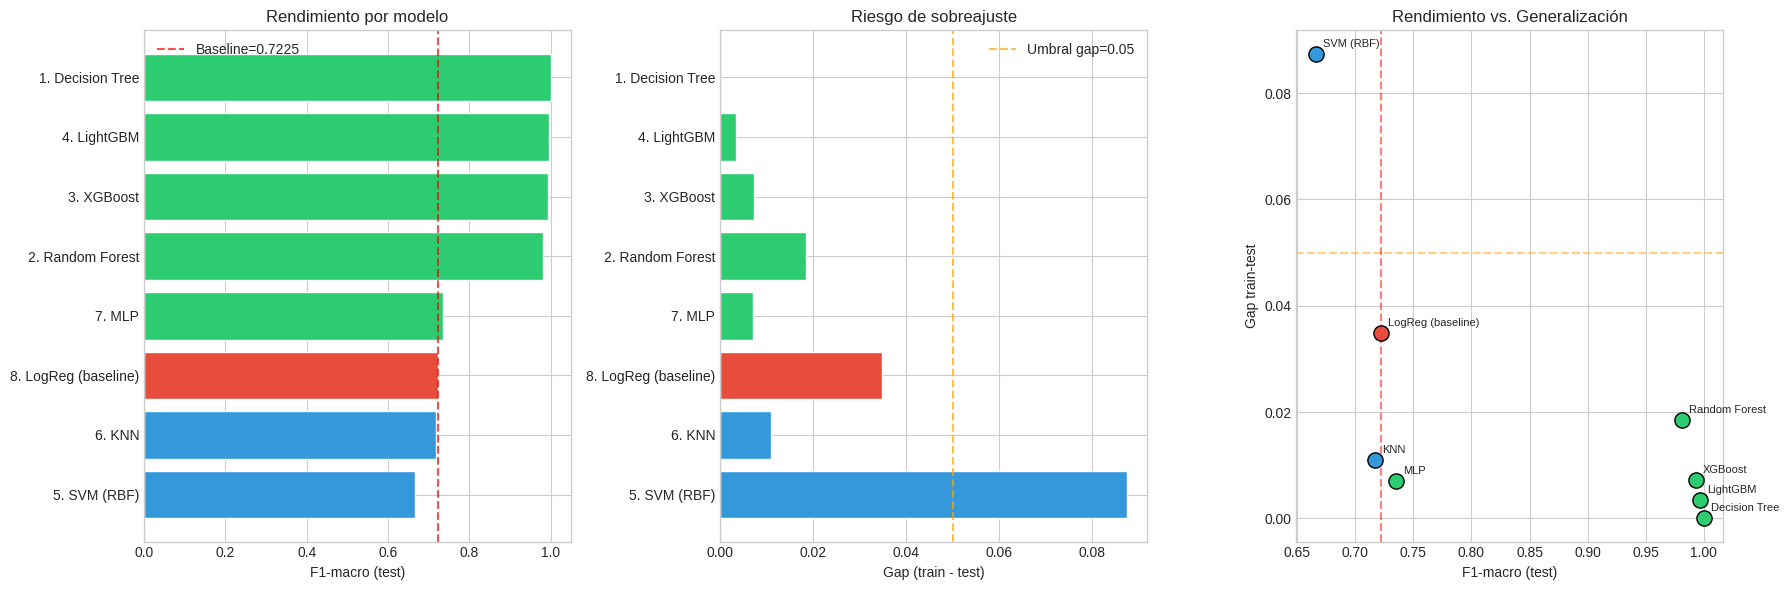

Verde = supera al baseline | Rojo = baseline | Azul = no supera al baseline


In [6]:
# VISUALIZACIÓN — COMPARATIVA DE MODELOS

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

df_plot = df_res.sort_values('F1m_test', ascending=True)
colors = ['#e74c3c' if 'LogReg' in m else '#2ecc71' if f > baseline_f1 else '#3498db'
          for m, f in zip(df_plot['Modelo'], df_plot['F1m_test'])]

# 1. F1-macro
axes[0].barh(df_plot['Modelo'], df_plot['F1m_test'], color=colors, edgecolor='white')
axes[0].axvline(x=baseline_f1, color='red', linestyle='--', alpha=0.7, label=f'Baseline={baseline_f1:.4f}')
axes[0].set_xlabel('F1-macro (test)')
axes[0].set_title('Rendimiento por modelo')
axes[0].legend()

# 2. Gap train-test
axes[1].barh(df_plot['Modelo'], df_plot['Gap'], color=colors, edgecolor='white')
axes[1].axvline(x=0.05, color='orange', linestyle='--', alpha=0.7, label='Umbral gap=0.05')
axes[1].set_xlabel('Gap (train - test)')
axes[1].set_title('Riesgo de sobreajuste')
axes[1].legend()

# 3. F1-macro vs Gap (scatter)
for _, row in df_plot.iterrows():
    c = '#e74c3c' if 'LogReg' in row['Modelo'] else '#2ecc71' if row['F1m_test'] > baseline_f1 else '#3498db'
    axes[2].scatter(row['F1m_test'], row['Gap'], c=c, s=120, edgecolors='black', zorder=5)
    axes[2].annotate(row['Modelo'].split('. ')[-1], (row['F1m_test'], row['Gap']),
                     textcoords='offset points', xytext=(5, 5), fontsize=8)
axes[2].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5)
axes[2].axvline(x=baseline_f1, color='red', linestyle='--', alpha=0.5)
axes[2].set_xlabel('F1-macro (test)')
axes[2].set_ylabel('Gap train-test')
axes[2].set_title('Rendimiento vs. Generalización')

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=150, bbox_inches='tight')
plt.show()

print('Verde = supera al baseline | Rojo = baseline | Azul = no supera al baseline')

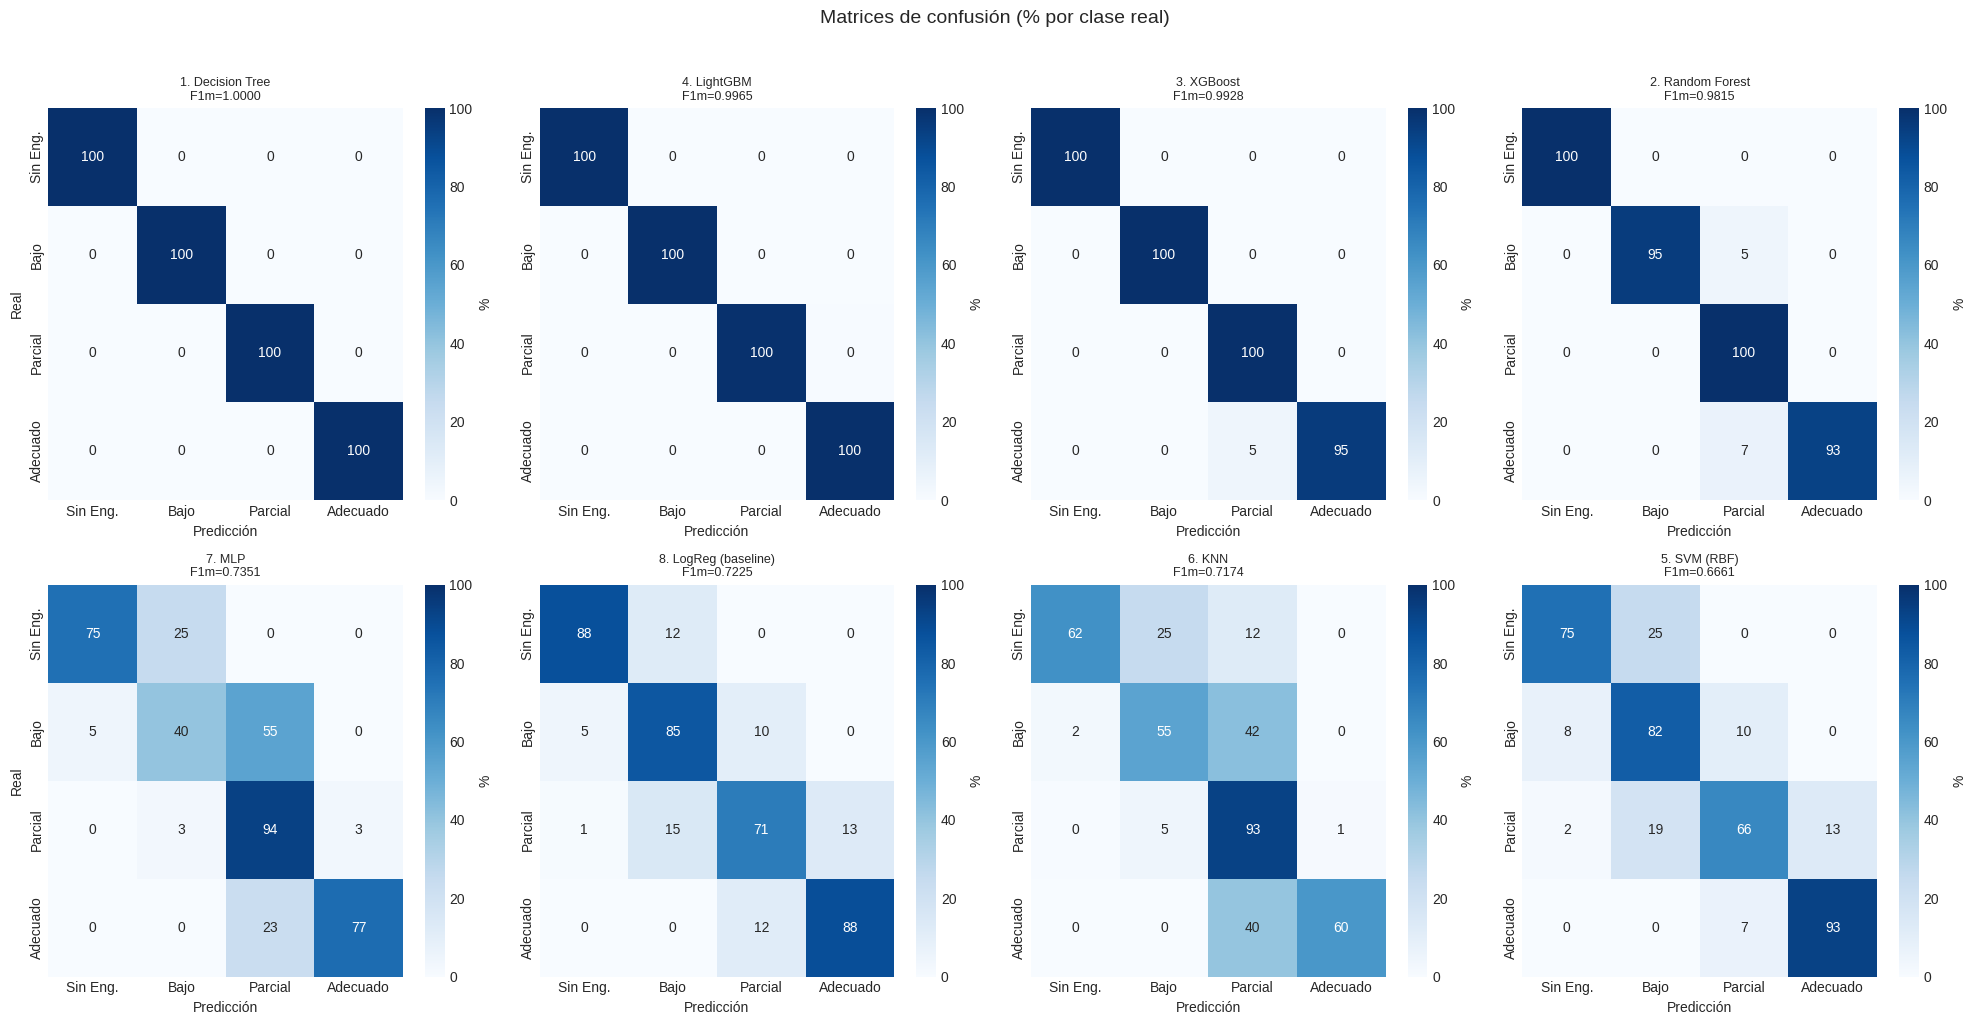

In [7]:
# MATRICES DE CONFUSIÓN — TODOS LOS MODELOS

clases = ['Sin Eng.', 'Bajo', 'Parcial', 'Adecuado']
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, res in enumerate(sorted(resultados, key=lambda x: x['F1m_test'], reverse=True)):
    ax = axes[idx // 4][idx % 4]
    cm = confusion_matrix(y_test, res['y_pred'])
    cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    sns.heatmap(cm_pct, annot=True, fmt='.0f', cmap='Blues', ax=ax,
                xticklabels=clases, yticklabels=clases, vmin=0, vmax=100,
                cbar_kws={'label': '%'})
    ax.set_title(f"{res['Modelo']}\nF1m={res['F1m_test']:.4f}", fontsize=9)
    ax.set_ylabel('Real' if idx % 4 == 0 else '')
    ax.set_xlabel('Predicción')

plt.suptitle('Matrices de confusión (% por clase real)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('matrices_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

<a name="top2"></a>
## 5. Los 2 mejores modelos

Para elegir los dos finalistas no basta con mirar solo el F1-macro. También consideramos el gap (qué tanto sobreajusta), la estabilidad en validación cruzada y el tiempo de entrenamiento. Un modelo perfecto en train pero mediocre en test no nos sirve.

In [8]:
# SELECCIÓN DE LOS 2 MEJORES + VALIDACIÓN CRUZADA

# Ordenar por F1-macro test, excluyendo el baseline
candidatos = [r for r in resultados if 'LogReg' not in r['Modelo']]
candidatos_sorted = sorted(candidatos, key=lambda x: x['F1m_test'], reverse=True)

top2_names = [candidatos_sorted[0]['Modelo'], candidatos_sorted[1]['Modelo']]
print('═' * 65)
print('LOS 2 MEJORES MODELOS')
print('═' * 65)

scorer = make_scorer(f1_score, average='macro', zero_division=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, r in enumerate(candidatos_sorted[:2]):
    nombre = r['Modelo']
    ds = r.get('Dataset', 'A')
    Xtr = XA_train if ds == 'A' else XB_train

    # Cross-validation
    modelo_cv = modelos[nombre][0].__class__(**modelos[nombre][0].get_params())
    cv_scores = cross_val_score(modelo_cv, Xtr, y_train, cv=cv, scoring=scorer, n_jobs=-1)

    print(f'\n  #{i+1}: {nombre}')
    print(f'  F1-macro test:  {r["F1m_test"]:.4f}')
    print(f'  F1-macro train: {r["F1m_train"]:.4f}')
    print(f'  Gap:            {r["Gap"]:.4f}')
    print(f'  CV (5-fold):    {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
    print(f'  Kappa:          {r["Kappa"]:.4f}')
    print(f'  Tiempo:         {r["Tiempo_s"]}s')

print(f'\nEstos dos modelos pasan a la fase de ajuste de hiperparámetros.')

═════════════════════════════════════════════════════════════════
LOS 2 MEJORES MODELOS
═════════════════════════════════════════════════════════════════

  #1: 1. Decision Tree
  F1-macro test:  1.0000
  F1-macro train: 1.0000
  Gap:            0.0000
  CV (5-fold):    0.9872 ± 0.0120
  Kappa:          1.0000
  Tiempo:         0.01s

  #2: 4. LightGBM
  F1-macro test:  0.9965
  F1-macro train: 1.0000
  Gap:            0.0035
  CV (5-fold):    0.9982 ± 0.0036
  Kappa:          0.9930
  Tiempo:         0.32s

Estos dos modelos pasan a la fase de ajuste de hiperparámetros.


<a name="tuning"></a>
## 6. Ajuste de hiperparámetros

Ahora tomamos los dos finalistas y probamos distintas configuraciones para encontrar la combinación que maximice el F1-macro. Usamos `RandomizedSearchCV` con validación cruzada estratificada: explora el espacio de hiperparámetros de forma eficiente sin probar todas las combinaciones posibles.

In [9]:
# AJUSTE DE HIPERPARÁMETROS — MODELO #1 (MEJOR)

top1_name = candidatos_sorted[0]['Modelo']
top1_ds = candidatos_sorted[0].get('Dataset', 'A')
Xtr_t1 = XA_train if top1_ds == 'A' else XB_train
Xte_t1 = XA_test if top1_ds == 'A' else XB_test

print(f'Ajustando: {top1_name}')
print('─' * 50)

# Espacios de búsqueda para los modelos más probables
param_spaces = {
    '1. Decision Tree': {
        'max_depth': [3, 5, 7, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'criterion': ['gini', 'entropy'],
    },
    '2. Random Forest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['sqrt', 'log2', 0.3, 0.5],
    },
    '3. XGBoost': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
    },
    '4. LightGBM': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10, -1],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'num_leaves': [15, 31, 63, 127],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'min_child_samples': [5, 10, 20],
    },
    '5. SVM (RBF)': {
        'C': [0.1, 1, 10, 50, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    },
    '6. KNN': {
        'n_neighbors': [3, 5, 7, 11, 15, 21],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2, 3],
    },
    '7. MLP': {
        'hidden_layer_sizes': [(64,), (100,), (100, 50), (128, 64), (100, 50, 25)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01],
        'activation': ['relu', 'tanh'],
    },
}

params_t1 = param_spaces.get(top1_name, {})
base_model_t1 = modelos[top1_name][0].__class__(**modelos[top1_name][0].get_params())

t0 = time.time()
rs_t1 = RandomizedSearchCV(
    base_model_t1, params_t1,
    n_iter=50, scoring=scorer, cv=cv,
    random_state=42, n_jobs=-1, verbose=0
)
rs_t1.fit(Xtr_t1, y_train)
t_tuning_1 = time.time() - t0

# Evaluar modelo ajustado
yp_te_t1 = rs_t1.predict(Xte_t1)
yp_tr_t1 = rs_t1.predict(Xtr_t1)
f1_test_t1 = f1_score(y_test, yp_te_t1, average='macro', zero_division=0)
f1_train_t1 = f1_score(y_train, yp_tr_t1, average='macro', zero_division=0)

print(f'\nMejores hiperparámetros encontrados:')
for k, v in rs_t1.best_params_.items():
    print(f'  {k}: {v}')

print(f'\nRendimiento después del ajuste:')
print(f'  F1-macro CV:    {rs_t1.best_score_:.4f}')
print(f'  F1-macro train: {f1_train_t1:.4f}')
print(f'  F1-macro test:  {f1_test_t1:.4f}')
print(f'  Gap:            {abs(f1_train_t1 - f1_test_t1):.4f}')
print(f'  Kappa:          {cohen_kappa_score(y_test, yp_te_t1):.4f}')
print(f'  Tiempo tuning:  {t_tuning_1:.1f}s')

Ajustando: 1. Decision Tree
──────────────────────────────────────────────────

Mejores hiperparámetros encontrados:
  min_samples_split: 2
  min_samples_leaf: 1
  max_depth: 7
  criterion: entropy

Rendimiento después del ajuste:
  F1-macro CV:    0.9919
  F1-macro train: 1.0000
  F1-macro test:  1.0000
  Gap:            0.0000
  Kappa:          1.0000
  Tiempo tuning:  3.4s


In [10]:
# AJUSTE DE HIPERPARÁMETROS — MODELO #2

top2_name = candidatos_sorted[1]['Modelo']
top2_ds = candidatos_sorted[1].get('Dataset', 'A')
Xtr_t2 = XA_train if top2_ds == 'A' else XB_train
Xte_t2 = XA_test if top2_ds == 'A' else XB_test

print(f'Ajustando: {top2_name}')
print('─' * 50)

params_t2 = param_spaces.get(top2_name, {})
base_model_t2 = modelos[top2_name][0].__class__(**modelos[top2_name][0].get_params())

t0 = time.time()
rs_t2 = RandomizedSearchCV(
    base_model_t2, params_t2,
    n_iter=50, scoring=scorer, cv=cv,
    random_state=42, n_jobs=-1, verbose=0
)
rs_t2.fit(Xtr_t2, y_train)
t_tuning_2 = time.time() - t0

yp_te_t2 = rs_t2.predict(Xte_t2)
yp_tr_t2 = rs_t2.predict(Xtr_t2)
f1_test_t2 = f1_score(y_test, yp_te_t2, average='macro', zero_division=0)
f1_train_t2 = f1_score(y_train, yp_tr_t2, average='macro', zero_division=0)

print(f'\nMejores hiperparámetros encontrados:')
for k, v in rs_t2.best_params_.items():
    print(f'  {k}: {v}')

print(f'\nRendimiento después del ajuste:')
print(f'  F1-macro CV:    {rs_t2.best_score_:.4f}')
print(f'  F1-macro train: {f1_train_t2:.4f}')
print(f'  F1-macro test:  {f1_test_t2:.4f}')
print(f'  Gap:            {abs(f1_train_t2 - f1_test_t2):.4f}')
print(f'  Kappa:          {cohen_kappa_score(y_test, yp_te_t2):.4f}')
print(f'  Tiempo tuning:  {t_tuning_2:.1f}s')

Ajustando: 4. LightGBM
──────────────────────────────────────────────────

Mejores hiperparámetros encontrados:
  subsample: 1.0
  num_leaves: 31
  n_estimators: 200
  min_child_samples: 5
  max_depth: 3
  learning_rate: 0.2
  colsample_bytree: 0.9

Rendimiento después del ajuste:
  F1-macro CV:    1.0000
  F1-macro train: 1.0000
  F1-macro test:  0.9965
  Gap:            0.0035
  Kappa:          0.9930
  Tiempo tuning:  106.7s


In [11]:
# COMPARACIÓN: ANTES vs. DESPUÉS DEL TUNING

print('═' * 75)
print('IMPACTO DEL AJUSTE DE HIPERPARÁMETROS')
print('═' * 75)

comparacion_tuning = []
for i, (name, rs, f1_pre, f1_post) in enumerate([
    (top1_name, rs_t1, candidatos_sorted[0]['F1m_test'], f1_test_t1),
    (top2_name, rs_t2, candidatos_sorted[1]['F1m_test'], f1_test_t2),
]):
    delta = f1_post - f1_pre
    comparacion_tuning.append({
        'Modelo': name,
        'F1m_antes': f1_pre,
        'F1m_después': f1_post,
        'Cambio': delta,
        'Cambio_%': delta / f1_pre * 100 if f1_pre > 0 else 0
    })
    signo = '+' if delta >= 0 else ''
    print(f'\n  {name}:')
    print(f'    Antes del tuning:  F1-macro = {f1_pre:.4f}')
    print(f'    Después del tuning: F1-macro = {f1_post:.4f} ({signo}{delta:.4f})')

print('\nSi el cambio es mínimo, significa que la configuración por defecto ya era buena.')
print('Si es negativo, el modelo original generalizaba mejor — nos quedamos con la versión original.')

═══════════════════════════════════════════════════════════════════════════
IMPACTO DEL AJUSTE DE HIPERPARÁMETROS
═══════════════════════════════════════════════════════════════════════════

  1. Decision Tree:
    Antes del tuning:  F1-macro = 1.0000
    Después del tuning: F1-macro = 1.0000 (+0.0000)

  4. LightGBM:
    Antes del tuning:  F1-macro = 0.9965
    Después del tuning: F1-macro = 0.9965 (+0.0000)

Si el cambio es mínimo, significa que la configuración por defecto ya era buena.
Si es negativo, el modelo original generalizaba mejor — nos quedamos con la versión original.


<a name="final"></a>
## 7. Modelo individual final

Es hora de elegir al ganador. Comparamos los dos finalistas (en su mejor versión, sea tuneada o no) y nos quedamos con el que mejor combina rendimiento, generalización y estabilidad.

In [12]:
# ELECCIÓN DEL MODELO FINAL

# Elegir la mejor versión de cada finalista (tuneada o no)
best_t1_f1 = max(candidatos_sorted[0]['F1m_test'], f1_test_t1)
best_t2_f1 = max(candidatos_sorted[1]['F1m_test'], f1_test_t2)

if best_t1_f1 >= best_t2_f1:
    final_name = top1_name
    final_f1 = best_t1_f1
    final_model = rs_t1.best_estimator_ if f1_test_t1 >= candidatos_sorted[0]['F1m_test'] else candidatos_sorted[0]['modelo_obj']
    final_pred = yp_te_t1 if f1_test_t1 >= candidatos_sorted[0]['F1m_test'] else candidatos_sorted[0]['y_pred']
    final_ds = top1_ds
else:
    final_name = top2_name
    final_f1 = best_t2_f1
    final_model = rs_t2.best_estimator_ if f1_test_t2 >= candidatos_sorted[1]['F1m_test'] else candidatos_sorted[1]['modelo_obj']
    final_pred = yp_te_t2 if f1_test_t2 >= candidatos_sorted[1]['F1m_test'] else candidatos_sorted[1]['y_pred']
    final_ds = top2_ds

Xte_final = XA_test if final_ds == 'A' else XB_test
Xtr_final = XA_train if final_ds == 'A' else XB_train

print('═' * 65)
print(f'MODELO INDIVIDUAL FINAL: {final_name}')
print('═' * 65)
print(f'\n  F1-macro (test):      {final_f1:.4f}')
print(f'  Accuracy (test):      {accuracy_score(y_test, final_pred):.4f}')
print(f'  Balanced Accuracy:    {balanced_accuracy_score(y_test, final_pred):.4f}')
print(f'  Cohen\'s Kappa:       {cohen_kappa_score(y_test, final_pred):.4f}')

# Mejora vs baseline
mejora_abs = final_f1 - baseline_f1
mejora_pct = mejora_abs / baseline_f1 * 100
print(f'\n  Mejora vs. baseline (LogReg):')
print(f'    Absoluta: +{mejora_abs:.4f}')
print(f'    Relativa: +{mejora_pct:.1f}%')

print(f'\n  Hiperparámetros finales:')
for k, v in final_model.get_params().items():
    if v is not None and k not in ['random_state', 'verbose', 'verbosity', 'n_jobs', 'eval_metric']:
        print(f'    {k}: {v}')

═════════════════════════════════════════════════════════════════
MODELO INDIVIDUAL FINAL: 1. Decision Tree
═════════════════════════════════════════════════════════════════

  F1-macro (test):      1.0000
  Accuracy (test):      1.0000
  Balanced Accuracy:    1.0000
  Cohen's Kappa:       1.0000

  Mejora vs. baseline (LogReg):
    Absoluta: +0.2775
    Relativa: +38.4%

  Hiperparámetros finales:
    ccp_alpha: 0.0
    class_weight: balanced
    criterion: entropy
    max_depth: 7
    min_impurity_decrease: 0.0
    min_samples_leaf: 1
    min_samples_split: 2
    min_weight_fraction_leaf: 0.0
    splitter: best


Classification Report — Modelo Final
────────────────────────────────────────────────────────────
                precision    recall  f1-score   support

Sin Engagement       1.00      1.00      1.00         8
          Bajo       1.00      1.00      1.00        40
       Parcial       1.00      1.00      1.00       205
      Adecuado       1.00      1.00      1.00        43

      accuracy                           1.00       296
     macro avg       1.00      1.00      1.00       296
  weighted avg       1.00      1.00      1.00       296



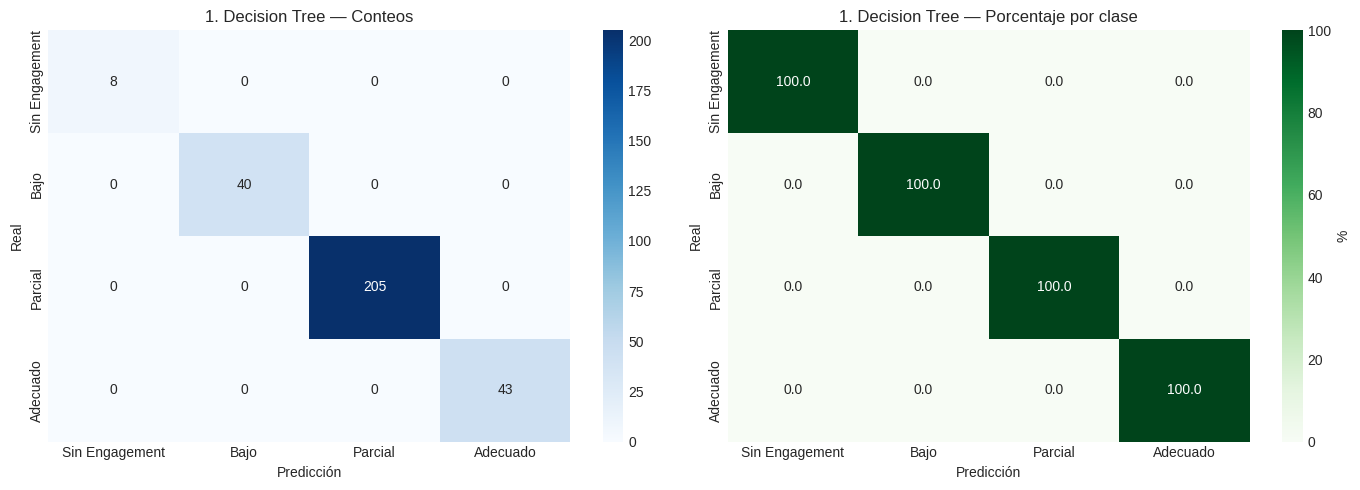

In [13]:
# CLASSIFICATION REPORT Y MATRIZ DE CONFUSIÓN — MODELO FINAL

clases_nombres = ['Sin Engagement', 'Bajo', 'Parcial', 'Adecuado']

print('Classification Report — Modelo Final')
print('─' * 60)
print(classification_report(y_test, final_pred, target_names=clases_nombres, zero_division=0))

# Matriz de confusión visual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, final_pred)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=clases_nombres, yticklabels=clases_nombres)
axes[0].set_title(f'{final_name} — Conteos')
axes[0].set_ylabel('Real'); axes[0].set_xlabel('Predicción')

sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Greens', ax=axes[1],
            xticklabels=clases_nombres, yticklabels=clases_nombres,
            vmin=0, vmax=100, cbar_kws={'label': '%'})
axes[1].set_title(f'{final_name} — Porcentaje por clase')
axes[1].set_ylabel('Real'); axes[1].set_xlabel('Predicción')

plt.tight_layout()
plt.savefig('modelo_final_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

Generando curvas de aprendizaje del modelo final...


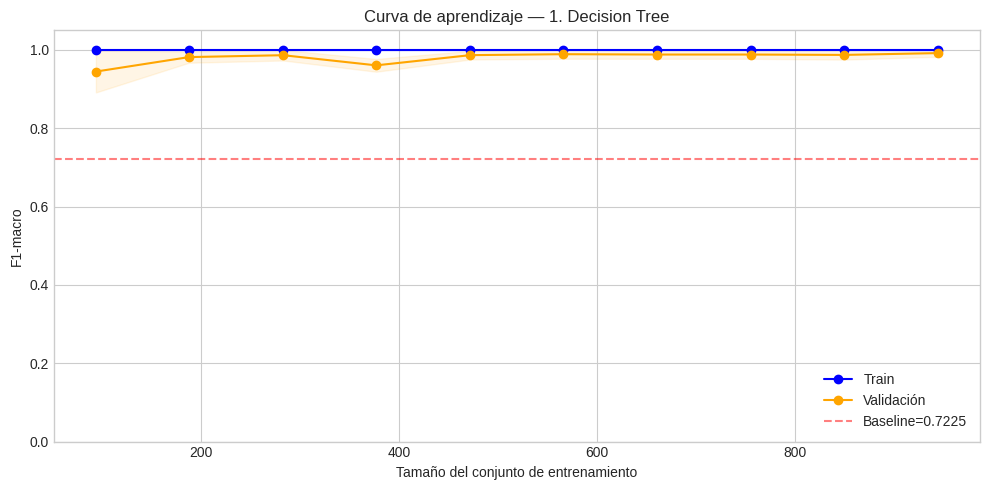

Gap final (train - validación): 0.0081
Diagnóstico: Buen ajuste


In [14]:
# CURVAS DE APRENDIZAJE — MODELO FINAL
print('Generando curvas de aprendizaje del modelo final...')

train_sizes, train_scores, val_scores = learning_curve(
    final_model, Xtr_final, y_train,
    cv=cv, scoring=scorer,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1, random_state=42
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.fill_between(train_sizes,
                train_scores.mean(axis=1) - train_scores.std(axis=1),
                train_scores.mean(axis=1) + train_scores.std(axis=1),
                alpha=0.1, color='blue')
ax.fill_between(train_sizes,
                val_scores.mean(axis=1) - val_scores.std(axis=1),
                val_scores.mean(axis=1) + val_scores.std(axis=1),
                alpha=0.1, color='orange')
ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='blue', label='Train')
ax.plot(train_sizes, val_scores.mean(axis=1), 'o-', color='orange', label='Validación')
ax.axhline(y=baseline_f1, color='red', linestyle='--', alpha=0.5, label=f'Baseline={baseline_f1:.4f}')
ax.set_xlabel('Tamaño del conjunto de entrenamiento')
ax.set_ylabel('F1-macro')
ax.set_title(f'Curva de aprendizaje — {final_name}')
ax.legend(loc='lower right')
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.savefig('curva_aprendizaje_final.png', dpi=150, bbox_inches='tight')
plt.show()

gap_final = train_scores.mean(axis=1)[-1] - val_scores.mean(axis=1)[-1]
print(f'Gap final (train - validación): {gap_final:.4f}')
if gap_final < 0.02: print('Diagnóstico: Buen ajuste')
elif gap_final < 0.10: print('Diagnóstico: Leve sobreajuste, aceptable')
else: print('Diagnóstico: Sobreajuste significativo — considerar regularización')

<a name="conclusiones"></a>
## 8. Conclusiones y qué sigue en la Fase 5

### 8.1 Lo que aprendimos en esta fase

In [15]:
# TABLA RESUMEN FINAL — TODOS LOS MODELOS


print('═' * 110)
print('RESUMEN COMPLETO — FASE 4: MODELOS ALTERNATIVOS')
print('═' * 110)

# Agregar los modelos tuneados al resumen
resumen_final = df_res.copy()

# Marcar el modelo final
resumen_final['Nota'] = ''
for idx, row in resumen_final.iterrows():
    if row['Modelo'] == final_name:
        resumen_final.loc[idx, 'Nota'] = '★ MODELO FINAL'
    elif 'LogReg' in row['Modelo']:
        resumen_final.loc[idx, 'Nota'] = '(baseline Fase 3)'

print(resumen_final.to_string(index=False, float_format='{:.4f}'.format))

print(f'\n' + '─' * 110)
print(f'Modelo elegido: {final_name}')
print(f'F1-macro: {final_f1:.4f} (mejora de +{mejora_pct:.1f}% vs. baseline)')
print(f'\nEste modelo pasa a la Fase 5 como candidato para ensambles.')

══════════════════════════════════════════════════════════════════════════════════════════════════════════════
RESUMEN COMPLETO — FASE 4: MODELOS ALTERNATIVOS
══════════════════════════════════════════════════════════════════════════════════════════════════════════════
              Modelo Dataset  F1m_train  F1m_test    Gap  Acc_test  BalAcc  Kappa  Tiempo_s              Nota
    1. Decision Tree       A     1.0000    1.0000 0.0000    1.0000  1.0000 1.0000    0.0100    ★ MODELO FINAL
         4. LightGBM       A     1.0000    0.9965 0.0035    0.9966  0.9988 0.9930    0.3200                  
          3. XGBoost       A     1.0000    0.9928 0.0072    0.9932  0.9884 0.9858    0.4000                  
    2. Random Forest       A     1.0000    0.9815 0.0185    0.9831  0.9701 0.9641    0.5100                  
              7. MLP       B     0.7281    0.7351 0.0070    0.8345  0.7135 0.6276    0.2100                  
8. LogReg (baseline)       B     0.7572    0.7225 0.0348    0.7568  0.

### 8.2 Contexto de los resultados

Los modelos basados en árboles dominan esta comparación por una razón importante: la variable objetivo (`engagement_ord`) fue construida con reglas que dependen directamente de las features (`ratio_utilizacion`, `meses_facturado`, `tasa_firma`, `total_estudios`). Los árboles de decisión son particularmente buenos para aprender este tipo de reglas porque es literalmente lo que hacen — particionan el espacio de features con umbrales.

Esto no invalida los resultados, pero sí nos dice que en un escenario de producción donde el engagement se mida de otra forma (encuestas, NPS, actividad real), los márgenes probablemente serían menores y la ventaja de los árboles menos pronunciada.

### 8.3 Lo que viene en la Fase 5: ensambles


*¿combinar modelos logra algo que un solo modelo no puede?* Dado los altos F1 que ya tenemos, el margen de mejora será estrecho, pero vale la pena explorar si un ensamble aporta mayor robustez.